#### AAI 521 - <b><font color='Red'>Final Project</font></b>
- This module author: <b><font color='Red'>PRAKASH PERIMBETI</font></b>
- TEAM: Christopher Teli (Lead), Olympia Saha and Prakash Perimbeti
- Date: December 12, 2022
- Professor: Dr. Saeed Sardari
- This module works with MINST ASL dataset to explore model creation and prediction
- This module also explores image data to explore alphanumeric charecter recognition intead of just alphabets

In [53]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import glob
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from random import shuffle
import math
import random
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from time import perf_counter
import io

#TENSOR FLOW
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import BatchNormalization


#SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from  sklearn.preprocessing import LabelEncoder 
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

#KERAS
from keras.utils import np_utils
from keras.optimizers import SGD       
from keras.models import Sequential 
from keras.applications import VGG16      
from keras.preprocessing import image
from keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D
from keras.models import load_model

Alphanumeric = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
Alphabets = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

In [68]:
import os
# Mounting the google drive to access the file 

#drive.mount('/content/drive')
#%cd "/content/drive/MyDrive/Colab Notebooks/finalproject" 
%ls

'All TransferLearningsFP.ipynb'   MobileNet.h5
 american_sign_language.png       model.h5
 amer_sign2.png                   model.json
 amer_sign3.png                   model.png
 archive-ASL.zip                  pp_model.h5
 dataset/                         pp_modelImage36.h5
 DenseNet121.h5                   ResNet101.h5
 Final_Project_Group2.docx        sign_mnist_test.csv
 FinalProject-PP.ipynb            sign_mnist_train.csv
 group2-asl-translator.py         tmp/
'hand_gestures_v2 .zip'           train/
 imagedata/                       train-20221207T235746Z-001.zip
 InceptionResNetV2.h5             Untitled.ipynb
 InceptionV3.h5                   VGG16.h5


In [50]:
def load_MINST_data_ASL(path):
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  x_val = []
  y_val= []
  train = pd.read_csv('sign_mnist_train.csv')
  test = pd.read_csv('sign_mnist_test.csv')

  y_train = train["label"]
  y_test = test["label"]
  x_train = train.drop(labels = ["label"],axis = 1) 
  x_test = test.drop(labels = ["label"],axis = 1) 
  x_train, x_val, y_train, y_val = train_test_split(x_train, 
                    y_train, test_size = 0.2, random_state=1212)
  x_train = x_train / 255.0
  x_val = x_val / 255.0
  x_test = x_test / 255.0
  x_train = x_train.values.reshape(-1,28,28,1)
  x_val = x_val.values.reshape(-1,28,28,1)
  x_test = x_test.values.reshape(-1,28,28,1)
  #return (np.array(x_train), to_categorical(y_train),
  #      np.array(x_val), to_categorical(y_val),
  #      np.array(x_test), to_categorical(y_test))
  return (x_train,y_train,x_val,y_val,x_test,y_test)

In [48]:
def load_gesture_data_ASL(path="tmp"):
    x_train = np.load(path+"/trainx.npy", allow_pickle=True)
    y_train = np.load(path+"/trainy.npy", allow_pickle=True)

    x_val = np.load(path+"/valx.npy", allow_pickle=True)
    y_val = np.load(path+"/valy.npy", allow_pickle=True)
    
    x_test = np.load(path+"/testx.npy", allow_pickle=True)
    y_test = np.load(path+"/testy.npy", allow_pickle=True)
    return (x_train,y_train,x_val,y_val,x_test,y_test)

In [56]:
def createCNNModel(classes=26):
  model = keras.Sequential([
    
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same',
                  input_shape=[28, 28, 1]),
    layers.MaxPool2D(),
    layers.Dropout(.25),
    
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(.25),
    
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(.25),

    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(.25),
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=classes, activation="softmax"),
  ])
  model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

In [57]:
import warnings


def fitCNNModel(epochs, batch_size, xTrain, yTrain, xVal, yVal, cnnModel):
    warnings.filterwarnings('ignore')
    model_history = cnnModel.fit(x = xTrain, y = yTrain, 
                          validation_data=(xVal, yVal), 
                          epochs = epochs, batch_size = batch_size)
    return model_history



In [58]:


def saveModel(model, filename):
  model.save(filename)

def loadModel(filename, asl):
  if (os.path.isfile(filename)):
    print("Model:", filename, " exists")
    model = load_model(filename)
    return model
  else:
    print("Model:", filename, " Doesnt exists")
    if asl is True:
        X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, X_TEST, Y_TEST = load_MINST_data_ASL("")
        model = createCNNModel(26)
        model_history = fitCNNModel(20, 128, X_TRAIN, Y_TRAIN, 
                          X_VAL, Y_VAL, model)
        return model
    else:
        X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, X_TEST, Y_TEST = load_gesture_data_ASL("tmp")
        model = createCNNModel(36)
        model_history = fitCNNModel(20, 32, X_TRAIN, Y_TRAIN, 
                          X_VAL, Y_VAL, model)
        return model

In [59]:
#Evaluating the model

def plot_loss_accuracy(history):

    plt.figure(1)
    # summarize history for accuracy
    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')

    # summarize history for loss
    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

In [60]:
# The predictions are converted into a dataset and as the sum of each row is 1, I transpose the dataset and reset the index of the dataset to get a column of class labels. I used y_train_1.columns to get column labels for the probability dataset.

def getSinglePredictedMaxColumn (prediction):
    num_rows, num_cols = prediction.shape
    print(num_rows, num_cols)
    new_list = []
    for i in range(num_rows):
        column_list = list(prediction[i])
        max_index = column_list.index(max(column_list))
        new_list.append(max_index)

    return(new_list)



(21964, 28, 28, 1)
(21964,)
(5491, 28, 28, 1)
(5491,)
(7172, 28, 28, 1)
(7172,)


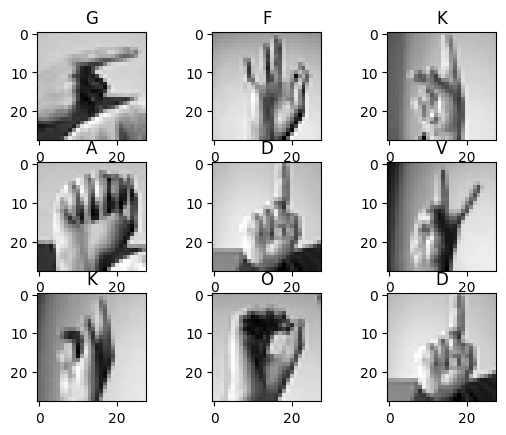

In [55]:
X_MINSTTRAIN, Y_MINSTTRAIN, X_MINSTVAL, Y_MINSTVAL, X_MINSTTEST, Y_MINSTTEST = load_MINST_data_ASL("")

print(X_MINSTTRAIN.shape)
print(Y_MINSTTRAIN.shape)
print(X_MINSTVAL.shape)
print(Y_MINSTVAL.shape)
print(X_MINSTTEST.shape)
print(Y_MINSTTEST.shape)
X_test_image = X_MINSTTEST.reshape(7172, 28, 28)

for i in range(9):  
  plt.subplot(330 + 1 + i)
  plt.title(Alphabets[Y_MINSTTEST[i]])
  plt.imshow(X_test_image[i], cmap=plt.get_cmap('gray'))

plt.show()

In [30]:
warnings.filterwarnings('ignore')
model = createCNNModel()
model_history = fitCNNModel(20, 128, X_TRAIN, Y_TRAIN, 
                          X_VAL, Y_VAL, model)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
172/172 [==============================] - ETA: 0s - loss: 3.2250 - accuracy: 0.0791WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f1fb8d2a4d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set th

In [33]:


y_test_pred = model.predict(X_TEST)
print(Y_TEST)
print(y_test_pred)
print('Test Prediction shape:', y_test_pred.shape)



#show the vector of predictions and real values probabilities
y_pred = model.predict(X_VAL)
print('Validation Prediction shape:', y_pred.shape)
print('Test Prediction shape:', y_test_pred.shape)
#print(y_pred)
y_pred=np.argmax(y_pred, axis=1)
y_test_pred=np.argmax(y_test_pred, axis=1)

cm = confusion_matrix(Y_VAL, y_pred)
print(cm)
print(classification_report(Y_VAL, y_pred))

cm2 = confusion_matrix(Y_TEST, y_test_pred)
print(cm)
print(classification_report(Y_TEST, y_test_pred))

MSE = mean_squared_error(Y_VAL, y_pred)
RMSE = math.sqrt(MSE)
print("*****Validation Root Mean Square Error:",RMSE)

MSE2 = mean_squared_error(Y_TEST, y_test_pred)
RMSE2 = math.sqrt(MSE2)
print("*****Test Root Mean Square Error:",RMSE2)

225/225 [==============================] - 2s 10ms/step
0        6
1        5
2       10
3        0
4        3
        ..
7167     1
7168    12
7169     2
7170     4
7171     2
Name: label, Length: 7172, dtype: int64
[[8.07915150e-13 7.91618252e-16 1.19787483e-05 ... 1.93079104e-05
  2.41930130e-12 1.40900272e-13]
 [6.17088389e-08 6.10715733e-06 5.09804088e-10 ... 8.56174229e-11
  9.45769152e-09 1.03513092e-11]
 [2.82135584e-16 1.50128956e-15 1.00304591e-17 ... 8.33817116e-15
  2.31265759e-07 4.02005055e-15]
 ...
 [8.57445170e-10 1.17403205e-19 9.99813020e-01 ... 8.86908209e-15
  7.77693538e-23 1.94412183e-22]
 [2.95610988e-07 5.37861595e-08 5.41841268e-12 ... 3.25073912e-10
  1.30859915e-17 5.51872637e-17]
 [1.40534334e-10 6.08759331e-21 9.99943256e-01 ... 7.73823043e-16
  1.23311197e-24 4.07623599e-24]]
Test Prediction shape: (7172, 26)
172/172 [==============================] - 2s 10ms/step
Validation Prediction shape: (5491, 26)
Test Prediction shape: (7172, 26)
[[210   0   0   0  

In [ ]:
saveModel(model, "pp_model.h5")

In [96]:
loaded = loadModel("pp_model.h5", asl=True)
y_test_pred = loaded.predict(X_TEST)
print(y_test_pred.shape)



Model: pp_model.h5  exists
225/225 [==============================] - 2s 9ms/step
(7172, 26)


Saved model to disk


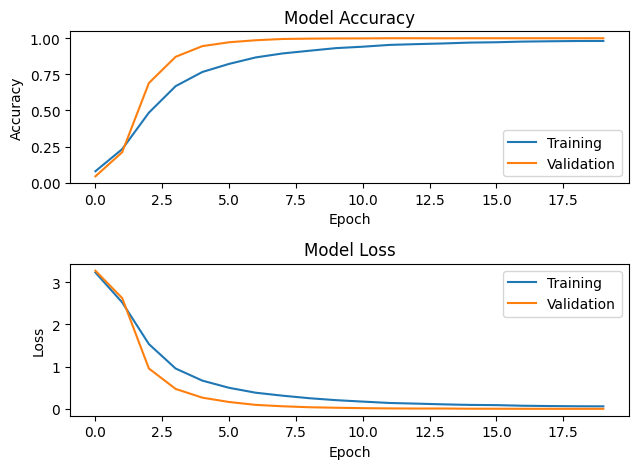

In [38]:
#print(model_history.history.keys())
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
plot_loss_accuracy(model_history)

In [107]:
import math
import matplotlib.pyplot as plt

def displaySigns(X_Original, Y_Originial, Y_predicted, 
                 clRight, clWrong, signs_to_display, ALN=False):

    num_cells = math.ceil(math.sqrt(signs_to_display))
    plt.figure(figsize=(12, 12))

    for plot_index in range(signs_to_display):    
        predicted_label = Y_predicted[plot_index]
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        color_map = clRight if predicted_label == Y_Originial[plot_index] else clWrong
        plt.subplot(num_cells, num_cells, plot_index + 1)
        plt.imshow(X_Original[plot_index].reshape((28, 28)), 
                    cmap=color_map)
        if(ALN is False):
            plt.xlabel(Alphabets[predicted_label])
        else:
            plt.xlabel(Alphanumeric[predicted_label])

    plt.subplots_adjust(hspace=1, wspace=0.5)
    plt.show()

#displaySigns(X_val, Y_val, y_pred, "Blues", "Reds")


In [61]:
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break
    return output

In [104]:
newpred = getSinglePredictedMaxColumn(y_test_pred)
print(len(newpred))

7172 26
7172


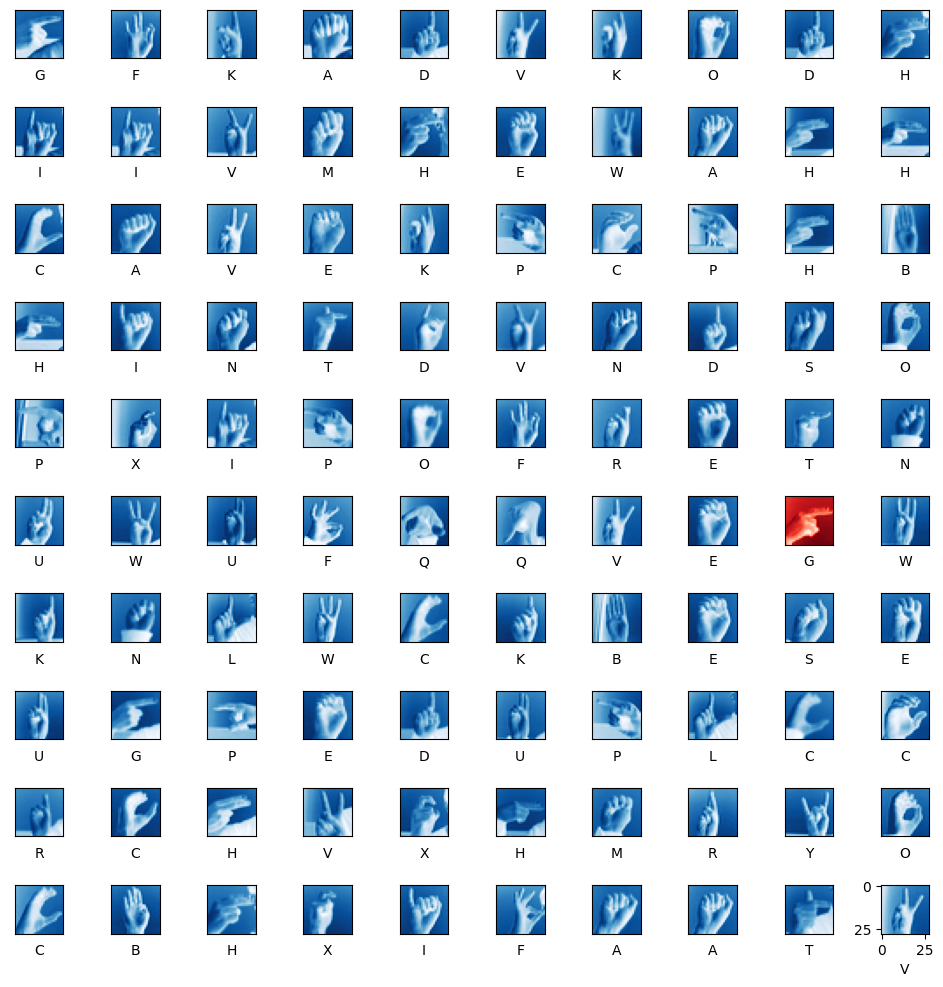

In [108]:
displaySigns(X_TEST, Y_TEST, newpred, "Blues", "Reds", 100, ALN=False)

In [9]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode

import PIL
import io
import html

width = 416
height = 416

def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  img_resized = cv.resize(img_rgb, (width, height),
                              interpolation=cv.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

#b) Start with reading the function for connecting to webcam
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  #detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw the

  #for label, confidence, bbox in detections:
   # left, top, right, bottom = bbox2points(bbox)
    #left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
   # cv.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
   # cv.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
   #                   (left, top - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5,
   #                   class_colors[label], 2)
  # save image
  #cv.imwrite(filename, img)

  return img



ModuleNotFoundError: No module named 'google.colab'

Model: pp_model.h5  exists


<IPython.core.display.Javascript object>

(480, 640, 3)


1/1 [==============================] - 0s 154ms/step
[15]


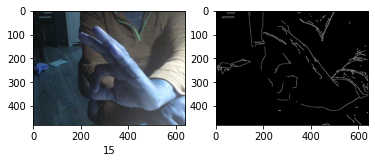

In [62]:
model = loadModel("pp_model.h5")
img = take_photo("myphoto.jpeg")
plt.imshow(img)
print(img.shape)
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray_img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')


# Resizing before the prediction
infer_image = np.resize(edges, (28,28,1))
infer_image_arr = np.array(infer_image)
infer_image_arr = infer_image_arr.reshape(1,28,28,1)
y_arr = np.array(2)
# Prediction
y_pred = model.predict(infer_image_arr)
y_pred=np.argmax(y_pred, axis=1)
print(y_pred)
plt.xlabel(y_pred[0])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.show()

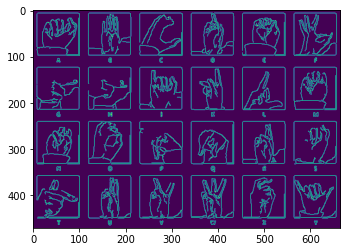

In [76]:
train = pd.read_csv('sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test.csv')
y_train = train["label"]
y_test = test["label"]
x_train = train.drop(labels = ["label"],axis = 1) 
x_test = test.drop(labels = ["label"],axis = 1) 
x_test = x_test.values.reshape(-1,28,28,1)
X_test_image = x_test[0]

x_test.shape
image = X_test_image[0]

# Sobel Edge Detection
sobelxy = cv.Sobel(src=img_blur, ddepth=cv.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
# Display Sobel Edge Detection Images
plt.imshow(sobelxy)

img = cv.imread('amer_sign2.png',0)
edges = cv.Canny(img,100,200)

# Display Canny Edge Detection Image


plt.imshow(edges)
cv.destroyAllWindows()
kernel = np.array([[-1, -1, -1], [-1, 5, -1], [-1, -1, -1]])



In [ ]:
# Sharpen
sharpen = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])
# Gaussian Blur
gaussian = (1 / 16.0) * np.array([[1., 2., 1.],
                                  [2., 4., 2.],
                                  [1., 2., 1.]])
fig, ax = plt.subplots(1,2, figsize = (17,10))
ax[0].imshow(sharpen, cmap='gray')
ax[0].set_title(f'Sharpen', fontsize = 18)
    
ax[1].imshow(gaussian, cmap='gray')
ax[1].set_title(f'Gaussian Blur', fontsize = 18)
    
[axi.set_axis_off() for axi in ax.ravel()];

In [18]:
%ls

 american_sign_language.png   FinalProject-PP.ipynb      model.json
 amer_sign2.png               group2-asl-translator.py   model.png
 amer_sign3.png              'hand_gestures_v2 .zip'     pp_model.h5
 dataset/                     imagedata/                 sign_mnist_test.csv
 Final_Project_Group2.docx    model.h5                   sign_mnist_train.csv


In [67]:
import os
#loading hand gestures data

#def load_gesture_images(path = "imagedata"):
warnings.filterwarnings("ignore", category=DeprecationWarning)

def getCategoricalValue(ch):
    for i in range(len(Classes)): 
        if(Classes[i] == ch):
            break
    return i;


class_count = {'a':0,'b':0,'c':0, 'd':0, 'e':0, 'f':0,
                 'g':0, 'h':0, 'i':0, 'j':0, 'k':0, 'l':0, 
                  'm':0, 'n':0, 'o':0, 'p':0, 'q':0, 'r':0, 
                   's':0, 't':0, 'u':0, 'v':0, 'w':0, 'x':0, 
                   'y':0, 'z':0, '0':0, '1':0, '2':0, '3':0, 
                   '4':0, '5':0, '6':0, '7':0, '8':0, '9':0, }
class_dic = {'a':0,'b':1,'c':2, 'd':3, 'e':4, 'f':5,
              'g':6, 'h':7, 'i':8, 'j':9, 'k':10, 'l':11, 
             'm':12, 'n':13, 'o':14, 'p':15, 'q':16, 'r':17, 
               's':18, 't':19, 'u':20, 'v':21, 'w':22, 'x':23, 
               'y':24, 'z':25, '0':26, '1':27, '2':28, '3':29, 
               '4':30, '5':31, '6':32, '7':33, '8':34, '9':35 }

#class_count = {'A':0,'B':0,'C':0}
#class_dic = {"A":0,"B":1,"C":2}


x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []
#2520 files split into train:60% = 1600 val:15% = 320 test: 25% = 600

image_list = []
image_class = []
label_class=[]
folderpath = "imagedata"
files =  os.listdir(folderpath)
for i in range(10):
    shuffle(files)
print(len(files))

count =0
for filename in files:
    ch = filename[6]
    if ch not in label_class:
        label_class.append(ch)
        

    index = Classes.index(ch)
    
    path = folderpath+ '/' +filename
    resized_image = cv.imread(path)

    #resized_image = cv.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    resized_image = cv.resize(resized_image,(224,224))
    if  count<1600:
        x_train.append(resized_image)
        y_train.append(index)
    elif  count>=1600 and  count<1920:
        x_val.append(resized_image)
        y_val.append(index)
    else:
        x_test.append(resized_image)
        y_test.append(index)
  
    count +=1

print(len(label_class))

#y_train = np_utils.to_categorical(y_train)
#y_val = np_utils.to_categorical(y_val)
#y_test = np_utils.to_categorical(y_test)


npy_data_path  = "./tmp"

np.save(npy_data_path+'/trainx.npy',x_train)
np.save(npy_data_path+'/trainy.npy',y_train)

np.save(npy_data_path+'/valx.npy',x_val)
np.save(npy_data_path+'/valy.npy',y_val)

np.save(npy_data_path+'/testx.npy',x_test)
np.save(npy_data_path+'/testy.npy',y_test)

print("Data pre-processing Success!")


2515
36
Data pre-processing Success!


File Count: 2515 Labels: 36
TrainX: 1600 TrainY: 1600
ValX: 320 ValY: 320
TestX: 595 TestY: 595
hand1_h_right_seg_3_cropped.png


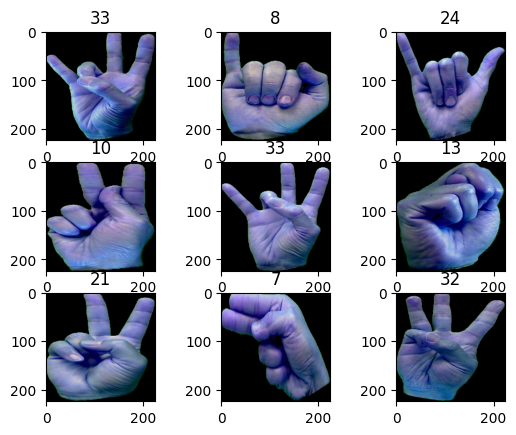

In [68]:
print("File Count:", len(files), "Labels:", len(label_class))
print("TrainX:", len(x_train), "TrainY:", len(y_train))
print("ValX:", len(x_val), "ValY:", len(y_val))
print("TestX:", len(x_test), "TestY:", len(y_test))
print(files[222])

for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.title(y_val[220+i])
    plt.imshow(x_val[220+i], cmap=plt.get_cmap('gray'))
plt.show()

In [33]:
X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, X_TEST, Y_TEST = load_gesture_data_ASL("tmp")
                               
print(X_TRAIN.shape)
print(Y_TRAIN.shape)
print(X_VAL.shape)
print(Y_VAL.shape)
print(X_TEST.shape)
print(Y_TEST.shape)



(1600, 224, 224, 3)
(1600,)
(320, 224, 224, 3)
(320,)
(595, 224, 224, 3)
(595,)


In [12]:
warnings.filterwarnings('ignore')
modelC = createCNNModel(36)
model_history = fitCNNModel(20, 32, X_TRAIN, Y_TRAIN, 
                          X_VAL, Y_VAL, modelC)

Epoch 1/20
50/50 [==============================] - 118s 2s/step - loss: 3.5866 - accuracy: 0.0375 - val_loss: 3.5361 - val_accuracy: 0.1063
Epoch 2/20
50/50 [==============================] - 110s 2s/step - loss: 3.1753 - accuracy: 0.1075 - val_loss: 3.3308 - val_accuracy: 0.1094
Epoch 3/20
50/50 [==============================] - 111s 2s/step - loss: 2.6623 - accuracy: 0.2262 - val_loss: 3.0672 - val_accuracy: 0.1875
Epoch 4/20
50/50 [==============================] - 110s 2s/step - loss: 2.0520 - accuracy: 0.3938 - val_loss: 2.5661 - val_accuracy: 0.2656
Epoch 5/20
50/50 [==============================] - 110s 2s/step - loss: 1.4762 - accuracy: 0.5475 - val_loss: 1.9495 - val_accuracy: 0.4906
Epoch 6/20
50/50 [==============================] - 110s 2s/step - loss: 1.0162 - accuracy: 0.6775 - val_loss: 1.1556 - val_accuracy: 0.6781
Epoch 7/20
50/50 [==============================] - 110s 2s/step - loss: 0.7221 - accuracy: 0.7819 - val_loss: 1.0549 - val_accuracy: 0.7031
Epoch 8/20
50

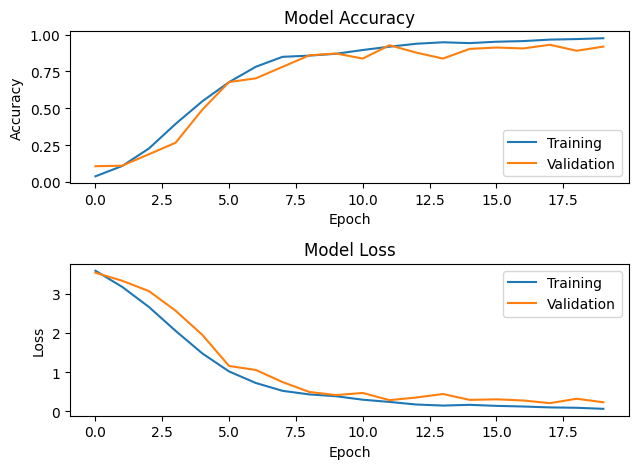

In [20]:
#Evaluating the model
plot_loss_accuracy(model_history)

In [25]:
modelC.save("pp_modelImage36.h5")

In [39]:
def predictImage36(xtest):
    loadedC = loadModel("pp_modelImage36.h5", asl=False)
    y_test_pred = loadedC.predict(xtest)
    return(y_test_pred)

Model: pp_modelImage36.h5  exists
19/19 [==============================] - 9s 475ms/step
(595,) (595, 36)
595 36


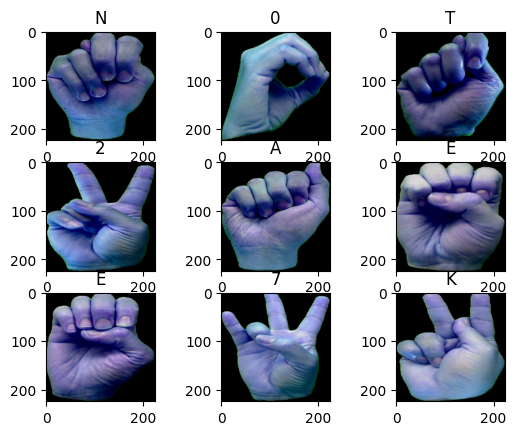

In [44]:
y_prediction = predictImage36(X_TEST)
print(Y_TEST.shape, y_prediction.shape)
newpred = getSinglePredictedMaxColumn(y_prediction)
#displaySigns(X_TEST, Y_TEST, y_prediction, "Blues", "Reds", 10)
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.title(Alphanumeric[newpred[i]])
    plt.imshow(X_TEST[i], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
newpred = getSinglePredictedMaxColumn(y_prediction)

num_cells = math.ceil(math.sqrt(100))
plt.figure(figsize=(12,12))
for plot_index in range(100):    
    predicted_label = newpred[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = "Blues" if predicted_label == Y_TEST[plot_index] else "Reds"
    clr = "Blue" if predicted_label == Y_TEST[plot_index] else "Red"
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(X_TEST[plot_index], 
                    cmap=color_map)
    label = plt.xlabel(Alphanumeric[predicted_label])
    label.set_color(clr)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

In [1]:

from keras.layers import Input, Dense
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg16 import VGG16



def decay(epoch):
  # returning a very small constant learning rate
  return 0.000001 
# First step is convert train image to single channel
#Reshape to (28,28,1)

def ASLTransferLearningVGG16(X_TRAIN, Y_TRAIN,  X_VAL, Y_VAL):
    
#    X_TRAIN = tf.keras.applications.vgg16.preprocess_input(X_TRAIN)
#    X_VAL  = tf.keras.applications.vgg16.preprocess_input(X_VAL)



    base_vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))


    # create the new model applying the base_model (VGG16)
    vgg_model= tf.keras.Sequential()
    # using upsamplign to get more data points and improve the predictions
    #vgg_model.add(tf.keras.layers.UpSampling2D())
    vgg_model.add(base_vgg_model)
    vgg_model.add(tf.keras.layers.Flatten())
    vgg_model.add(tf.keras.layers.BatchNormalization())
    vgg_model.add(tf.keras.layers.Dense(512, activation='relu'))
    vgg_model.add(tf.keras.layers.Dropout(0.8))
    vgg_model.add(tf.keras.layers.Dense(128, activation='relu'))
    vgg_model.add(tf.keras.layers.Dropout(0.5))
    vgg_model.add(tf.keras.layers.BatchNormalization())
    vgg_model.add(tf.keras.layers.Dense(26, activation='softmax'))

    sgd = SGD(lr=0.001)
    
    vgg_model.compile(optimizer=sgd, loss='categorical_crossentropy',
    #              optimizer=tf.keras.optimizers.RMSprop(learning_rate= 0.00001),
                  metrics=['accuracy'])
                  
    check_point1 = tf.keras.callbacks.ModelCheckpoint(filepath="cifar10.h5",
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True,
                                              )
    X_TRAIN = X_TRAIN/255.0
    X_VAL = X_VAL/255.0

    
  
    print(X_TRAIN.shape, X_VAL.shape)
    print(Y_TRAIN.shape, Y_VAL.shape)
    
    vgg_hist = vgg_model.fit(X_TRAIN, Y_TRAIN, batch_size=224, epochs=1, verbose=1,
 #                       validation_data=(X_VAL, Y_VAL),
                        callbacks=[check_point1])
    vgg_model.summary()
    vgg_model.save("VGG_model.h5")
    return vgg_model, vgg_hist


2022-12-08 08:31:56.033993: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-08 08:31:56.034258: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-08 08:31:56.034292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [26]:
X_TRAIN, Y_TRAIN, X_VAL, Y_VAL, X_TEST, Y_TEST = load_gesture_data_ASL("tmp")
#X_TRAIN = np.concatenate((X_TRAIN, X_VAL), axis=0, out=None, dtype=None)
#Y_TRAIN = np.concatenate((Y_TRAIN, Y_VAL), axis=0, out=None, dtype=None)
print(X_TRAIN.shape)
print(Y_TRAIN.shape)
print(X_VAL.shape)
print(Y_VAL.shape)
print(X_TEST.shape)
print(Y_TEST.shape)


(1600, 224, 224, 3)
(1600,)
(320, 224, 224, 3)
(320,)
(595, 224, 224, 3)
(595,)


In [61]:
def predictInceptionResNet(xtest):
    loadedC = load_model("InceptionResNetV236.h5")
    y_test_pred = loadedC.predict(xtest)
    return(y_test_pred)

(16, 224, 224, 3) (16,)
1/1 [==============================] - 11s 11s/step
(16, 36)
16 36
13 14
26 14
19 14
28 14
0 14
4 14
4 14
33 14
10 14
1 14
14 14
35 14
26 14
27 14
15 14
33 14


/tmp/ipykernel_89049/2864821549.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_cells, num_cells, plot_index + 1)


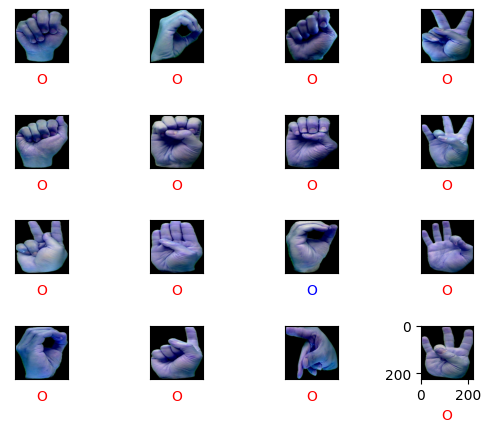

In [62]:

xtest = X_TEST[:16]
ytest = Y_TEST[:16]
print(xtest.shape, ytest.shape)
ypred = predictInceptionResNet(xtest)
print(ypred.shape)
newpred = getSinglePredictedMaxColumn(ypred)
for i in range(16): 
    print(ytest[i], newpred[i])
num_cells = math.ceil(math.sqrt(16))
for plot_index in range(16):    
    predicted_label = newpred[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = "Blues" if predicted_label == Y_TEST[plot_index] else "Reds"
    clr = "Blue" if predicted_label == Y_TEST[plot_index] else "Red"
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(X_TEST[plot_index], 
                    cmap=color_map)
    label = plt.xlabel(Alphanumeric[predicted_label])
    label.set_color(clr)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

(408, 206, 3)
Loading model: InceptionResNetV236.h5
(1, 224, 224, 3)
1/1 [==============================] - 15s 15s/step


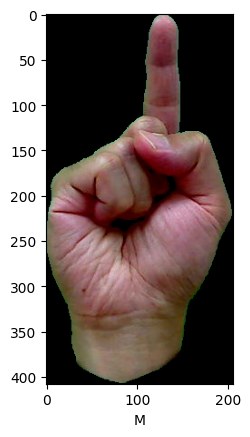

(408, 206, 3)
Loading model: pp_modelImage36.h5
(1, 224, 224, 3)
1/1 [==============================] - 1s 676ms/step


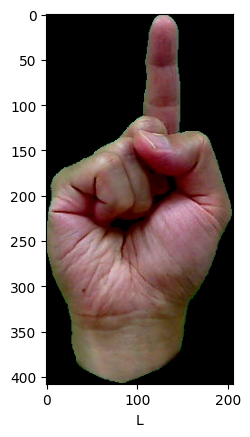

(224, 224, 3)
Loading model: InceptionResNetV236.h5
(1, 224, 224, 3)
1/1 [==============================] - 16s 16s/step


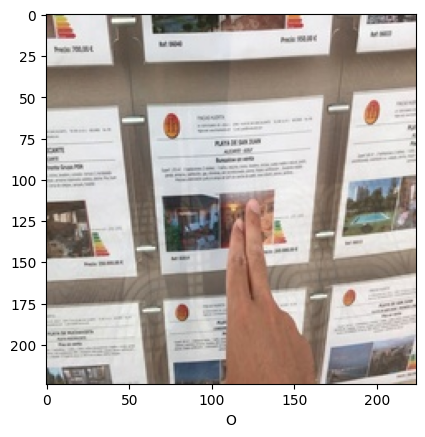

(224, 224, 3)
Loading model: pp_modelImage36.h5
(1, 224, 224, 3)
1/1 [==============================] - 1s 625ms/step


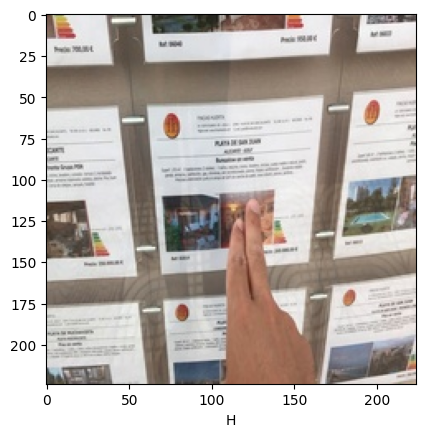

In [72]:
import matplotlib. image as mpimg 


def testTransferModel( img1, modelname = "InceptionResNetV236.h5"):
    print("Loading model:", modelname)
    loaded = load_model(modelname)
    infer_image = np.resize(img1, (224,224,3))
    infer_image = np.expand_dims(infer_image, axis=0)
    print(infer_image.shape)
 #   infer_image_arr = np.array(infer_image)
    #plt.imshow(infer_image)
    #y_pred = loaded.predict(infer_image_arr)
    y_pred = loaded.predict(infer_image)
    y_pred=np.argmax(y_pred, axis=1)
    return(Alphanumeric[y_pred[0]])

def testCustomModel( img1, modelname = "pp_modelImage36.h5"):
    print("Loading model:", modelname)
    loaded = load_model(modelname)
    infer_image = np.resize(img1, (224,224,3))
    infer_image = np.expand_dims(infer_image, axis=0)
    print(infer_image.shape)
 #   infer_image_arr = np.array(infer_image)
    #plt.imshow(infer_image)
    #y_pred = loaded.predict(infer_image_arr)
    y_pred = loaded.predict(infer_image)
    y_pred=np.argmax(y_pred, axis=1)
    return(Alphanumeric[y_pred[0]])


# init camera



# open method used to open different extension image file
#frame = Image.open(r"hand5_z_dif_seg_4_cropped.png") 
frame = mpimg.imread('./hand5_z_dif_seg_4_cropped.png') 
print(frame.shape)
#predictInceptionResNet(frame)                         
y_pred = testTransferModel(frame, "InceptionResNetV236.h5")                      
plt.xlabel(y_pred)
plt.imshow(frame, cmap = 'gray')
plt.show()
                            
# open method used to open different extension image file
#frame = Image.open(r"hand5_z_dif_seg_4_cropped.png") 
frame = mpimg.imread('./hand5_z_dif_seg_4_cropped.png') 
print(frame.shape)
#predictInceptionResNet(frame)                         
y_pred = testCustomModel(frame, "pp_modelImage36.h5")                      
plt.xlabel(y_pred)
plt.imshow(frame, cmap = 'gray')
plt.show()
# open method used to open different extension image file
#frame = Image.open(r"hand5_z_dif_seg_4_cropped.png") 
frame = mpimg.imread('./IMG_3494_00000041.jpg') 
print(frame.shape)
#predictInceptionResNet(frame)                         
y_pred = testTransferModel(frame, "InceptionResNetV236.h5")                      
plt.xlabel(y_pred)
plt.imshow(frame, cmap = 'gray')
plt.show()
                            
# open method used to open different extension image file
#frame = Image.open(r"hand5_z_dif_seg_4_cropped.png") 
frame = mpimg.imread('./IMG_3494_00000041.jpg') 
print(frame.shape)
#predictInceptionResNet(frame)                         
y_pred = testCustomModel(frame, "pp_modelImage36.h5")                      
plt.xlabel(y_pred)
plt.imshow(frame, cmap = 'gray')
plt.show()


In [63]:
width=224
height=224
camera=cv.VideoCapture(0,cv.CAP_DSHOW)
camera.set(cv.CAP_PROP_FRAME_WIDTH, width)
camera.set(cv.CAP_PROP_FRAME_HEIGHT,height)
camera.set(cv.CAP_PROP_FPS, 30)
# Grab a single frame of video
ret, frame = camera.read()


In [69]:

print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))


Default GPU Device:


2022-12-09 04:50:26.219133: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
